In [1]:
import os
import numpy as np

import scipy.ndimage.morphology as morph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from PIL import Image

to_pil = transforms.ToPILImage()
os.listdir('../r_unet/data/')

['images_val', 'labels_val', 'test', 'labels', 'images']

In [2]:
DEVICE = "cuda:1"
# arguments
TIMESTEPS = 3
BATCH_SIZE = 1
NUM_EPOCHS = 200
INPUT_SIZE = 128
INPUT_CHANNELS = 1
NUM_CLASSES = 2
LEARNING_RATE = 0.001

RECURRENT = True

transform = transforms.Compose([
                              transforms.Resize((INPUT_SIZE, INPUT_SIZE), interpolation = 0),
                              transforms.ToTensor()
                              ])

to_tensor = transforms.ToTensor()

# decive
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
# way to the data folders
FOLDER_DATA = "../r_unet/data/images"
FOLDER_MASK = "../r_unet/data/labels"
FOLDER_TEST = "../r_unet/data/test"
FOLDER_DATA_VAL = "../r_unet/data/images_val"
FOLDER_MASK_VAL = "../r_unet/data/labels_val"

FILE_NAMES = sorted(os.listdir('../r_unet/data/images'))
FILE_NAMES_VAL = sorted(os.listdir('../r_unet/data/images_val'))

In [4]:
def get_labels(object):
    label1 = (object==0).float()
    label2 = (label1==0).float()
    labels = torch.stack([label1, label2], dim=1).squeeze()
    return labels

In [5]:
class TrainMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA
        self.folder_mask = FOLDER_MASK
        self.file_names = FILE_NAMES

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
        gif_mask = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            img = Image.open(self.folder_mask + '/' + self.file_names[idx+i])
            img = img.resize((INPUT_SIZE, INPUT_SIZE), resample=Image.NEAREST)
            gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)))
        gif_depth = torch.stack(gif_list)
        return gif_data, gif_mask, gif_depth
    
    def __len__(self):
        return len(self.file_names) - self.time + 1


class ValMedData(Dataset):
    def __init__(self):
        super().__init__()
        self.time = TIMESTEPS
        self.folder_data = FOLDER_DATA_VAL
        self.folder_mask = FOLDER_MASK_VAL
        self.file_names = FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_data + '/' + self.file_names[idx+i])))
        gif_data = torch.stack(gif_list)
        gif_list.clear()
        for i in range(self.time):
            gif_list.append(get_labels(transform(Image.open(self.folder_mask + '/' + self.file_names[idx+i]))))
        gif_mask = torch.stack(gif_list).squeeze(dim=2)
        gif_list.clear()
        for i in range(self.time):
            img = Image.open(self.folder_mask + '/' + self.file_names[idx+i])
            img = img.resize((INPUT_SIZE, INPUT_SIZE), resample=Image.NEAREST)
            gif_list.append(to_tensor(morph.distance_transform_edt(np.asarray(img)/255)))
        gif_depth = torch.stack(gif_list)
        return gif_data, gif_mask, gif_depth

    def __len__(self):
        return len(self.file_names) - self.time + 1


class TestMedData(Dataset):
    def __init__(self):
        super().__init__
        self.time = TIMESTEPS
        self.folder_test = FOLDER_TEST
        self.file_names = FILE_NAMES + FILE_NAMES_VAL

    def __getitem__(self, idx):
        gif_list = []
        for i in range(self.time):
            gif_list.append(transform(Image.open(self.folder_test + '/' + self.file_names[idx+i])))
        gif_test = torch.stack(gif_list)
        gif_list.clear()
        return gif_test

    def __len__(self):
        return len(self.file_names) - self.time + 1

In [6]:
train_dataset = TrainMedData()
valid_dataset = ValMedData()
test_dataset = TestMedData()

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=1,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         num_workers=1,
                         shuffle=False)

data_loaders = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'test': len(test_dataset)
}

In [7]:
x, y, z =train_dataset[0]
x.shape

torch.Size([3, 1, 128, 128])

In [8]:
class ConvRnnCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvRnnCell, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
             
    def forward(self, x, hidden):
        out = torch.cat([x, hidden],dim=1)
        out = self.conv1(out)
        hidden = out
        return out, hidden

In [9]:
class ConvGruCell(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(ConvGruCell, self).__init__()
        self.conv_relu_for_input = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_relu_for_hidden = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        
        self.conv_relu_2x_update = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        self.conv_relu_2x_reset = nn.Sequential(nn.Conv2d(in_channels+out_channels, out_channels, kernel_size=3, padding=1))
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

     
    def forward(self, x, hidden):
        input = torch.cat([x, hidden],dim=1)

        update_gate = self.conv_relu_2x_update(input)
        update_gate = self.relu((update_gate)) ### output after update gate
        reset_gate = self.conv_relu_2x_reset(input)
        reset_gate = self.relu((reset_gate)) ### output after reset gate
        
        
        memory_gate_for_input = self.conv_relu_for_input(x)
        memory_gate_for_hidden = self.conv_relu_for_hidden(hidden)

        memory_content = memory_gate_for_input + (reset_gate * memory_gate_for_hidden) ### output for reset gate(affects how the reset gate do work)
        memory_content = self.relu(memory_content)

        hidden = (update_gate * hidden) + ((1 - update_gate) * memory_content) # torch.ones(input_size, hidden_size)

        return hidden, hidden

In [10]:
class ConvRnn(nn.Module):
    def __init__(self, in_channels, out_channels, ConvRnn_input_size): # arg for ConvRnn layer
        super(ConvRnn, self).__init__()
        self.batch_size = BATCH_SIZE
        self.timesteps = TIMESTEPS
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.hidden_size = (self.batch_size, self.out_channels, self.input_size, self.input_size)
        
        self.ConvRnn_layer = ConvRnnCell(in_channels, out_channels)
        self.init_hidden = torch.zeros(self.hidden_size).to(device)
        self.rec = RECURRENT


    def forward(self, x):
        x_cells = None
        x_list = []

        x = x.reshape(self.batch_size, self.timesteps, self.in_channels, self.input_size, self.input_size)
        x = x.permute(1, 0, 2, 3, 4)
        for i in range(self.timesteps):
            if x_cells is None:
                x_cells, hidden = self.ConvRnn_layer(x[i], self.init_hidden)
                x_list.append(x_cells)
            else:
                x_i, hidden = self.ConvRnn_layer(x[i], hidden)
                x_list.append(x_i)
        x_cells = torch.stack(x_list)
        x_cells = x_cells.permute(1, 0, 2, 3, 4)

        x_cells = x_cells.reshape(-1, self.out_channels, self.input_size, self.input_size)
        return x_cells  

In [11]:
class ConvRnnRelu(nn.Module):
    def __init__(self, in_channels, out_channels ,ConvRnn_input_size):
        super(ConvRnnRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_size = ConvRnn_input_size
        self.convrnnrelu = nn.Sequential(ConvRnn(self.in_channels, self.out_channels, self.input_size),
                                         nn.ReLU()
                                         )

    def forward(self, x):
        return self.convrnnrelu(x)

In [12]:
class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvRelu, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.convrelu = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1),
                                      nn.ReLU()
                                      )

    def forward(self, x):
        return self.convrelu(x)

In [13]:
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        return self.maxpool(x)    

In [14]:
class UpAndCat(nn.Module):    
    def __init__(self):
        super(UpAndCat, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x_up, x_cat):
        out = self.up(x_up)
        out = torch.cat([out, x_cat], dim=1)
        return out

In [15]:
class UNetDesigner(nn.Module):    
    def __init__(self, d1, d2, d3, b, u1, u2, u3,
                 input_size=INPUT_SIZE, input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES):
        super(UNetDesigner, self).__init__()
        self.num_classes = NUM_CLASSES
        self.d1, self.d2, self.d3, self.b, self.u1, self.u2, self.u3 = d1, d2, d3, b, u1, u2, u3
        self.input_size = input_size
        self.input_chennels = input_channels
        self.ch_list = [self.input_chennels, 32, 64, 128, 256]
        self.input_x2 = int(self.input_size / 2)
        self.input_x4 = int(self.input_size / 4)
        self.input_x8 = int(self.input_size / 8)
         # Down_1 layer
        if self.d1 == True:                                                       #input_size = 128      # Channels
            self.down1 = nn.Sequential(ConvRnnRelu(self.ch_list[0], self.ch_list[1], self.input_size),   # 1  -->32
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                        # 32 -->32
                                       )
        else:    
            self.down1 = nn.Sequential(ConvRelu(self.ch_list[0], self.ch_list[1]),                       # 1  -->32
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                        # 32 -->32
                                       )
        self.down1_pool = MaxPool()
         # Down_2 layer                                                           #input_size = 64
        if self.d2 == True:
            self.down2 = nn.Sequential(ConvRnnRelu(self.ch_list[1], self.ch_list[2], self.input_x2),     # 32 -->64
                                       ConvRelu(self.ch_list[2], self.ch_list[2])                        # 64 -->64
                                       )
        else:
            self.down2 = nn.Sequential(ConvRelu(self.ch_list[1], self.ch_list[2]),                       # 32 -->64
                                       ConvRelu(self.ch_list[2], self.ch_list[2])                        # 64 -->64
                                       )
        self.down2_pool = MaxPool()
         # Down_3 layer                                                           #input_size = 32
        if self.d3 == True:
            self.down3 = nn.Sequential(ConvRnnRelu(self.ch_list[2], self.ch_list[3], self.input_x4),     # 64 -->128
                                       ConvRelu(self.ch_list[3], self.ch_list[3])                        # 128-->128
                                       )
        else:
            self.down3 = nn.Sequential(ConvRelu(self.ch_list[2], self.ch_list[3]),                       # 64 -->128
                                       ConvRelu(self.ch_list[3], self.ch_list[3])                        # 128-->128
                                       )
        self.down3_pool = MaxPool()
         # Bottom layer                                                           #input_size = 16
        if self.b == True:
            self.bottom = nn.Sequential(ConvRnnRelu(self.ch_list[3], self.ch_list[4], self.input_x8),    # 128-->256
                                        ConvRelu(self.ch_list[4], self.ch_list[4]),                      # 256-->256
                                        )
        else:
            self.bottom = nn.Sequential(ConvRelu(self.ch_list[3], self.ch_list[4]),                      # 128-->256
                                        ConvRelu(self.ch_list[4], self.ch_list[4]),                      # 256-->256
                                        )
         # Up_3 layer
        self.up_cat_3 = UpAndCat()
        self.up_conv_3 = nn.Sequential(ConvRelu(self.ch_list[4]+self.ch_list[3], self.ch_list[3]),       # 394-->128
                                       ConvRelu(self.ch_list[3], self.ch_list[3])                        # 128-->128
                                       )
         # Up_2 layer
        self.up_cat_2 = UpAndCat()
        self.up_conv_2 = nn.Sequential(ConvRelu(self.ch_list[3]+self.ch_list[2], self.ch_list[2]),       # 192-->64
                                       ConvRelu(self.ch_list[2], self.ch_list[2])                        # 64 -->64
                                       )
         # Up_1 layer
        self.up_cat_1 = UpAndCat()
        self.up_conv_1 = nn.Sequential(ConvRelu(self.ch_list[2]+self.ch_list[1], self.ch_list[1]),       # 96 -->32
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                        # 32 -->32
                                       )
         # Final layer
        self.final = nn.Sequential(nn.Conv2d(self.ch_list[1], self.num_classes, kernel_size=1),
                                   nn.Sigmoid(),
                                   )

    def forward(self, x):
        x = x.reshape(-1, self.input_chennels, self.input_size, self.input_size)
        # print(x.shape)
        down1_feat = self.down1(x)
        pool1 = self.down1_pool(down1_feat)
        # print(pool1.shape)
        down2_feat = self.down2(pool1)
        pool2 = self.down2_pool(down2_feat)
        # print(pool2.shape)
        down3_feat = self.down3(pool2)
        pool3 = self.down3_pool(down3_feat)
        # print(pool3.shape)
        bottom_feat = self.bottom(pool3)
        # print(bottom_feat.shape)
        up_feat3 = self.up_cat_3(bottom_feat, down3_feat)
        up_feat3 = self.up_conv_3(up_feat3)
        
        up_feat2 = self.up_cat_2(up_feat3, down2_feat)
        up_feat2 = self.up_conv_2(up_feat2)
        
        up_feat1 = self.up_cat_1(up_feat2, down1_feat)
        up_feat1 = self.up_conv_1(up_feat1)
        
        out = self.final(up_feat1)
        return out

In [16]:
class UNetGruAll(nn.Module):    
    def __init__(self, d1, d2, d3, b, u1, u2, u3,
                 input_size=INPUT_SIZE, input_channels=INPUT_CHANNELS, num_classes=NUM_CLASSES):
        super(UNetGruAll, self).__init__()
        self.num_classes = NUM_CLASSES
        self.d1, self.d2, self.d3, self.b, self.u1, self.u2, self.u3 = d1, d2, d3, b, u1, u2, u3
        self.input_size = input_size
        self.input_chennels = input_channels
        self.ch_list = [self.input_chennels, 32, 64, 128, 256]
        self.input_x2 = int(self.input_size / 2)
        self.input_x4 = int(self.input_size / 4)
        self.input_x8 = int(self.input_size / 8)
         # Down_1 layer
        if self.d1 == True:                                                       #input_size = 128      # Channels
            self.down1 = nn.Sequential(ConvRnnRelu(self.ch_list[0], self.ch_list[1], self.input_size),   # 1  -->32
                                       ConvRnnRelu(self.ch_list[1], self.ch_list[1], self.input_size)                        # 32 -->32
                                       )
        else:    
            self.down1 = nn.Sequential(ConvRelu(self.ch_list[0], self.ch_list[1]),                       # 1  -->32
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                        # 32 -->32
                                       )
        self.down1_pool = MaxPool()
         # Down_2 layer                                                           #input_size = 64
        if self.d2 == True:
            self.down2 = nn.Sequential(ConvRnnRelu(self.ch_list[1], self.ch_list[2], self.input_x2),   # 1  -->32
                                       ConvRnnRelu(self.ch_list[2], self.ch_list[2], self.input_x2)                        # 64 -->64
                                       )
        else:
            self.down2 = nn.Sequential(ConvRelu(self.ch_list[1], self.ch_list[2]),                       # 32 -->64
                                       ConvRelu(self.ch_list[2], self.ch_list[2])                        # 64 -->64
                                       )
        self.down2_pool = MaxPool()
         # Down_3 layer                                                           #input_size = 32
        if self.d3 == True:
            self.down3 = nn.Sequential(ConvRnnRelu(self.ch_list[2], self.ch_list[3], self.input_x4),   # 1  -->32
                                       ConvRnnRelu(self.ch_list[3], self.ch_list[3], self.input_x4)                        # 128-->128
                                       )
        else:
            self.down3 = nn.Sequential(ConvRelu(self.ch_list[2], self.ch_list[3]),                       # 64 -->128
                                       ConvRelu(self.ch_list[3], self.ch_list[3])                        # 128-->128
                                       )
        self.down3_pool = MaxPool()
         # Bottom layer                                                           #input_size = 16
        if self.b == True:
            self.bottom = nn.Sequential(ConvRnnRelu(self.ch_list[3], self.ch_list[4], self.input_x8),   # 1  -->32
                                       ConvRnnRelu(self.ch_list[4], self.ch_list[4], self.input_x8)                     # 256-->256
                                        )
        else:
            self.bottom = nn.Sequential(ConvRelu(self.ch_list[3], self.ch_list[4]),                      # 128-->256
                                        ConvRelu(self.ch_list[4], self.ch_list[4]),                      # 256-->256
                                        )
         # Up_3 layer
        self.up_cat_3 = UpAndCat()
        self.up_conv_3 = nn.Sequential(ConvRelu(self.ch_list[4]+self.ch_list[3], self.ch_list[3]),       # 394-->128
                                       ConvRelu(self.ch_list[3], self.ch_list[3])                        # 128-->128
                                       )
         # Up_2 layer
        self.up_cat_2 = UpAndCat()
        self.up_conv_2 = nn.Sequential(ConvRelu(self.ch_list[3]+self.ch_list[2], self.ch_list[2]),       # 192-->64
                                       ConvRelu(self.ch_list[2], self.ch_list[2])                        # 64 -->64
                                       )
         # Up_1 layer
        self.up_cat_1 = UpAndCat()
        self.up_conv_1 = nn.Sequential(ConvRelu(self.ch_list[2]+self.ch_list[1], self.ch_list[1]),       # 96 -->32
                                       ConvRelu(self.ch_list[1], self.ch_list[1])                        # 32 -->32
                                       )
         # Final layer
        self.final = nn.Sequential(nn.Conv2d(self.ch_list[1], self.num_classes, kernel_size=1),
                                   nn.Sigmoid(),
                                   )

    def forward(self, x):
        x = x.reshape(-1, self.input_chennels, self.input_size, self.input_size)
        # print(x.shape)
        down1_feat = self.down1(x)
        pool1 = self.down1_pool(down1_feat)
        # print(pool1.shape)
        down2_feat = self.down2(pool1)
        pool2 = self.down2_pool(down2_feat)
        # print(pool2.shape)
        down3_feat = self.down3(pool2)
        pool3 = self.down3_pool(down3_feat)
        # print(pool3.shape)
        bottom_feat = self.bottom(pool3)
        # print(bottom_feat.shape)
        up_feat3 = self.up_cat_3(bottom_feat, down3_feat)
        up_feat3 = self.up_conv_3(up_feat3)
        
        up_feat2 = self.up_cat_2(up_feat3, down2_feat)
        up_feat2 = self.up_conv_2(up_feat2)
        
        up_feat1 = self.up_cat_1(up_feat2, down1_feat)
        up_feat1 = self.up_conv_1(up_feat1)
        
        out = self.final(up_feat1)
        return out

In [17]:
x = torch.rand(2, 3, 1, 128, 128).to(device)
model = UNetDesigner(d1=True, d2=True, d3=True, b=True, u1=1, u2=1, u3=1)
model = model.to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def l2_norm(x, y):
    y = y.reshape(x.shape)
    return (((x - y)**2).sum(dim=2)).sum()

In [19]:
val_loss = []
for epoch in range(NUM_EPOCHS):
    print('*'*10, 'epoch: ', epoch, '*'*10)
    for phase in ['train', 'valid']:
        if phase == 'train':
            loss_list = []
            model.train()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = l2_norm(output, label)
                loss_list.append(loss.item())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            mean_loss = sum(loss_list) / len(loss_list)
            print("train l2_norm: ", mean_loss)
        elif phase == 'valid':
            loss_list = []
            model.eval()
            for i, data in enumerate(data_loaders[phase]):
                input, label, depth = data
                input = input.to(device)
                label = label.to(device)
                depth = depth.to(device)
                output = model(input)
                loss = l2_norm(output, label)
                loss_list.append(loss.item())
            mean_loss = sum(loss_list) / len(loss_list)
            print("val l2_norm: ", mean_loss)
            val_loss.append(mean_loss)
print('Minimum Valid Loss: ', min(val_loss))

********** epoch:  0 **********
train l2_norm:  18913.45751953125
val l2_norm:  15522.144205729166
********** epoch:  1 **********
train l2_norm:  16681.507057883522
val l2_norm:  15130.650065104166
********** epoch:  2 **********
train l2_norm:  16008.262517755682
val l2_norm:  14514.916666666666
********** epoch:  3 **********
train l2_norm:  15329.663751775568
val l2_norm:  13699.045735677084
********** epoch:  4 **********
train l2_norm:  13738.120472301136
val l2_norm:  12313.798177083334
********** epoch:  5 **********
train l2_norm:  12256.862571022728
val l2_norm:  11197.837076822916
********** epoch:  6 **********
train l2_norm:  11286.586381392046
val l2_norm:  10756.239095052084
********** epoch:  7 **********
train l2_norm:  11226.73086825284
val l2_norm:  11331.393880208334
********** epoch:  8 **********
train l2_norm:  11404.334605823864
val l2_norm:  12513.206380208334
********** epoch:  9 **********
train l2_norm:  10769.048872514204
val l2_norm:  11165.485026041666
**

train l2_norm:  6573.196222478693
val l2_norm:  8416.929931640625
********** epoch:  84 **********
train l2_norm:  6500.090420809659
val l2_norm:  8338.540201822916
********** epoch:  85 **********
train l2_norm:  6596.668235085227
val l2_norm:  8296.771321614584
********** epoch:  86 **********
train l2_norm:  6571.725985440341
val l2_norm:  7979.725260416667
********** epoch:  87 **********
train l2_norm:  6421.141268643466
val l2_norm:  8036.558186848958
********** epoch:  88 **********
train l2_norm:  6512.70146040483
val l2_norm:  7975.773274739583
********** epoch:  89 **********
train l2_norm:  6788.799183238636
val l2_norm:  8072.3193359375
********** epoch:  90 **********
train l2_norm:  6638.535600142045
val l2_norm:  7951.102620442708
********** epoch:  91 **********
train l2_norm:  6450.288219105114
val l2_norm:  7854.757731119792
********** epoch:  92 **********
train l2_norm:  6366.109929865057
val l2_norm:  7901.7734375
********** epoch:  93 **********
train l2_norm:  62

train l2_norm:  4682.912020596591
val l2_norm:  8166.48095703125
********** epoch:  167 **********
train l2_norm:  4756.835293856534
val l2_norm:  8013.414143880208
********** epoch:  168 **********
train l2_norm:  4788.939564098011
val l2_norm:  8042.138916015625
********** epoch:  169 **********
train l2_norm:  4684.900213068182
val l2_norm:  8360.08251953125
********** epoch:  170 **********
train l2_norm:  4374.6865789240055
val l2_norm:  8393.172037760416
********** epoch:  171 **********
train l2_norm:  4168.429620916193
val l2_norm:  8296.562255859375
********** epoch:  172 **********
train l2_norm:  4051.147804953835
val l2_norm:  8282.5087890625
********** epoch:  173 **********
train l2_norm:  3994.7197043678975
val l2_norm:  8296.1826171875
********** epoch:  174 **********
train l2_norm:  3963.3195578835225
val l2_norm:  8242.079345703125
********** epoch:  175 **********
train l2_norm:  4000.3650235262785
val l2_norm:  8209.20556640625
********** epoch:  176 **********
tra

In [20]:
output.shape

torch.Size([3, 2, 128, 128])

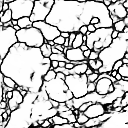

In [21]:
to_pil(output[0][1].cpu())